# Explore a NuGrid star model in iPython notebook

Modified for ASTR 404, Winter 2024. Execute this notebook on the [Astohub](https://astrohub.uvic.ca).


### Initialize session

In [1]:
%pylab ipympl
from nugridpy import mesa as ms
from nugridpy import nugridse as mp

data_dir="/data/ASDR/NuGrid"  
# data_dir = '/Users/fherwig/mnt/nugrid'

ms.set_nugrid_path(data_dir)
mp.set_nugrid_path(data_dir)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### The MESA stellar evolution model

By default MESA is putting out two types of data. History data provides the time evolution of scalar quantities, one per time step. This data can be accessed with the `mesa.star_log` (or `mesa.history_data` which is the same) class.

MESA also outputs profile data at select time steps. Profiles are available via the `mesa_profile` class.

#### History data
Initialise the 2 solar-mass Z=0.02 MESA stellar evolution model from set1.2 using the seeker method:

In [2]:
s=ms.star_log(mass=1,Z=0.02)   # or ms.history_data which is just an alias

nugrid_path = /Users/fherwig/mnt/nugrid
closest set is set1.2 (Z = 0.02)
closest mass is 1.0
Using old star.logsa file ...
 reading ...100% 



`s` is an instance of the history data, which is the table of scalar quantities such as mass, $T_\mathrm{eff}$ etc for each time step or model.

There are a number of pre-defined functions or methods associated with this instances, such as an HRD or a Kippenhahn diagram:

In [ ]:
ifig=102;close(ifig);figure(ifig)
s.hrd_new()
legend(loc='lower right').draw_frame(False)

 creating color map burn ...100% 

 creating color map mix ...100% 

engenstyle was  full
mixstyle was  full

 finished preparing color map
plot versus model number
plotting contours
plotting patches
plotting abund boundaries


/Users/fherwig/opt/anaconda3/envs/astrohub2/lib/python3.8/site-packages/nugridpy/mesa.py:2502: UserWarning: Log scale: values of z <= 0 have been masked
  CBURN1  = ax.contourf(xxx[::dx],y,B1, cmap=cmapB1, alpha=0.5,\
/Users/fherwig/opt/anaconda3/envs/astrohub2/lib/python3.8/site-packages/nugridpy/mesa.py:2505: UserWarning: Log scale: values of z <= 0 have been masked
  CB1_outlines  = ax.contour(xxx[::dx],y,B1, cmap=cmapB1, alpha=0.7, \


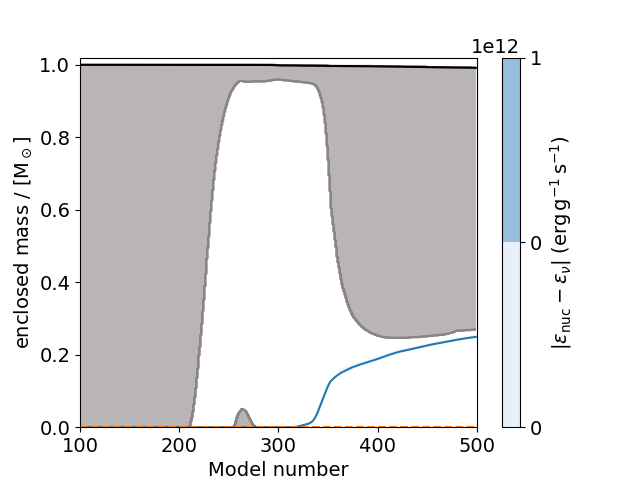

In [3]:
ifig=107;close(ifig);figure(ifig)
s.kip_cont(ifig=ifig, boundaries=True,engenlevels=[1e2,1e6,1e12],modstart=100,modstop=500)

Note that each function has a pythonic doc string, e.g. `s.kip_cont`. 

The `s.cols` command gives a list of available columns in the history file. Maybe the most important method is `s.get('col_name)` which returns an array with the data in the column with name `col_name`.

Below we demonstrate this by funding a model similar to that of our sun (age $\approx 4.6$ billion years, mass $1\mathrm{M_\odot}$ and $Z=0.02$ and then find the central temperature and pressure of that stellar model.

In [ ]:
# this is the array with the ages of the stellar models
s.get('star_age')

In [ ]:
# find the index that corresponds to the approximate age of the sun
# recall that we initiated `s` as a 1Msun, Z=0.02 model
ind_sun = where(s.get('star_age')<4.6e9)[0][-1]
ind_sun

In [ ]:
# let's check what quantities we have
s.cols

As we can see we have the central temperature as well as some other central quantities already listed as scalar quantities in the history file:

```
'log_center_T': 123,
 'log_center_Rho': 124,
 'log_center_P': 125,
 'center_mu': 126,
 'center_ye': 127,
 'center_h1': 128
 ```
 
 Therefore knowing the central T and P is straight forward:

In [ ]:
s.get('log_center_T')[ind_sun]

In [ ]:
s.get('log_center_P')[ind_sun]

In [ ]:
s.get('center_h1')[ind_sun]

We can find the same results also by looking at profile data from the MESA output.

#### MESA profile files
The `mesa.mesa_profile` class provides access to the available profile data. We can again use the seeker method to just find the righ model by initial mass and metallicity. An additional argument `num=` specifies the model number. This behaviour can be changed, see the doc string for details. Profiles are not available for all models, and the method will report which nearby model it has found.

In [ ]:
# The `prof` instance is now holding the data of one profile for the given model number in the `num=` argument.
prof=ms.mesa_profile(mass=1,Z=0.02,num=ind_sun)

In [ ]:
# Again, have a look at the available quantieis
prof.cols

In [ ]:
# The data is presented in arrays that go from the outside inward
# therefore the last element is the central value
prof.get('pressure')[-1]

In [ ]:
# Of course we can also plot profiles
ifig=108;close(ifig);figure(ifig)
plot(prof.get('rmid'),prof.get('mu'))

In [ ]:
ifig=108;close(ifig);figure(ifig)
prof.plot('mass','c12',shape='-')

In [ ]:
# get all header attributes, these are some scalar quantites (like the ones in the history instance)
prof.header_attr

The MESA data has a number of abundance profiles saved, but not all. These are available from the nucleosynthesis post-processing simulation with the `mppnp` code.

## Analyse the `mppnp` post-processing data

In the above example at model `500` the $1\mathrm{M_\odot}$ model star is in the Red Giant Branch phase with an inert He core and supported by H-shell burning. It has an extended convective envelope. Let's look at the abundance profiles at this stage. For this we are using the post-processing data. Just make sure you are selecting the same mass and Z value.

In [5]:
pt=mp.se(mass=1,Z=0.02)

nugrid_path = /Users/fherwig/mnt/nugrid
closest set is set1.2 (Z = 0.02)
closest mass is 1.0
Searching files, please wait.......
Reading preprocessor files
File search complete.


#### What quantities are available in this data type, and what are the units?
Each of the _se_ file sets (in fact each of the dozens of hdf5 files that make up the data set for one mass/metallicty combination, or stellar evolution track) has three types of data contained in them:

data type access | content 
----------------|---------
 `pt.se.hattrs` |  a header section that holds the _header attributes_, including units in the form of factors so that if applied with the quantities the result is in cgs units 
`pt.se.cattrs` | for each cycle (or time step) the _cycle attributes_ are a number of scalar global quantities, such as total mass or star age
`pt.se.dcols` | again, for each time step these are the vector quantities available, i.e. the data table columns; one of the data columns, _iso_massf_ is in fact a matrix where the matrix columns are different species, i.e. a radial vector of species vectors

We can use the `get` method to pull any of the data. But for some standard plots there are pre-made methods available, such as for plotting the profiles of a number of isotopes. This method is the `pt.abu_profile` method. Have a look at the doc string.

In [6]:
pt.abu_profile?

Signature:
pt.abu_profile(
    ixaxis='mass',
    isos=None,
    ifig=None,
    fname=None,
    logy=False,
    colourblind=False,
)
Docstring:
Plot common abundances as a function of either mass coordiate or radius.

Parameters
----------
ixaxis : string, optional
    'mass',  'logradius' or 'radius'
    The default value is 'mass'
isos : list, optional
    list of isos to plot, i.e. ['h1','he4','c12'] for MESA or
    ['H-1','He-4','C-12'] for SE output. If None, the code decides
    itself what to plot.
    The default is None.
ifig : integer or string, optional
    The figure label
    The default value is None
fname : integer, optional
    What cycle to plot from (if SE output)
    The default value is None
logy : boolean, optional
    Should y-axis be logarithmic?
    The default value is False
colourblind : boolean, optional
    do you want to use the colourblind colour palette from the NuGrid
    nuutils module?
File:      ~/opt/anaconda3/envs/astrohub2/lib/python3.8/site-packag

 reading ['iso_massf']...100%

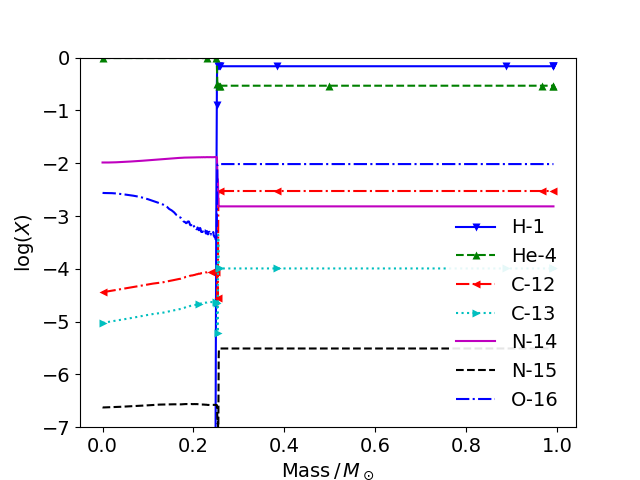

In [25]:
species=['H-1','He-4','C-12','C-13','N-14','N-15','O-16']
ifig=108;close(ifig);figure(ifig)
pt.abu_profile(isos=species, ifig=ifig, fname=500, logy=True)
ylim(-7,0)
legend(loc='lower right',fancybox=True, framealpha=0.9).get_frame().set_linewidth(0.0)

The interesting features are at mass coordinate $\approx 0.255 M_{\odot}$. Let's have a look at this in more detail.

 reading ['iso_massf']...100%

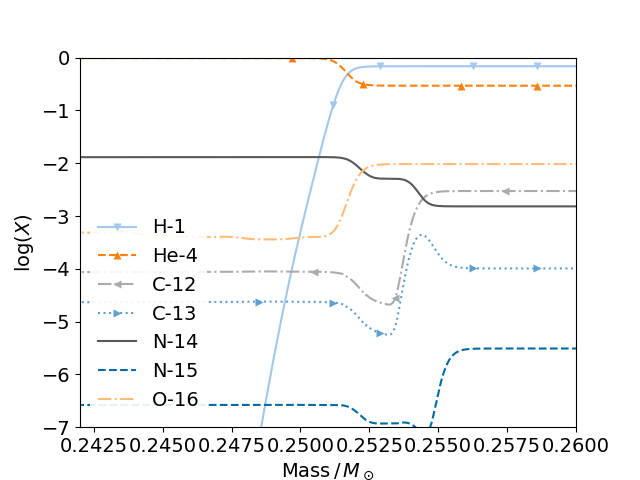

In [30]:
species=['H-1','He-4','C-12','C-13','N-14','N-15','O-16']
ifig=109;close(ifig);figure(ifig)
pt.abu_profile(isos=species, ifig=ifig, fname=500, logy=True, colourblind=True)
ylim(-7,0)
xlim(0.242,0.260)
legend(loc='lower left',fancybox=True, framealpha=0.9).get_frame().set_linewidth(0.0)

Explain the abundance profiles that you see in the above plot in terms of the CN cycle H-burning.